In [1]:
import csv
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

2022-12-11 19:15:03.047150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 19:15:03.539242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gblake/ros2_ws/install/simple_filter/lib:/home/gblake/ros2_ws/install/neato2_interfaces/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-12-11 19:15:03.539262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set 

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [3]:
NUM_CLASSES = 10

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2022-12-11 19:15:11.142789: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-12-11 19:15:11.142833: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gblake-Latitude-5411
2022-12-11 19:15:11.142845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gblake-Latitude-5411
2022-12-11 19:15:11.143017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2022-12-11 19:15:11.143078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-12-11 19:15:11.143091: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.86.1 -- cannot find working devices in this configuration
2022-12-11 19:15:11.143588: I tensorflow/core/platform/cpu_feature_guard

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/8 [==>...........................] - ETA: 13s - loss: 2.3888 - accuracy: 0.0703
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
8/8 [==============================] - 3s 125ms/step - loss: 2.3538 - accuracy: 0.0653 - val_loss: 2.3154 - val_accuracy: 0.0530
Epoch 2/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.3234 - accuracy: 0.0625
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
8/8 [==============================] - 0s 30ms/step - loss: 2.3184 - accuracy: 0.0808 - val_loss: 2.2744 - val_accuracy: 0.1291
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 2.2871 - accuracy: 0.1228
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
8/8 [==============================] - 0s 32ms/step - loss: 2.2871 - accuracy: 0.1228 - val_loss: 2.2385 - val_accuracy: 0.1556
Epoch 4/1000
1/8 [==>...........................] - ETA: 0s - loss: 2.2704 - accuracy: 0.0625
Epoch 4: s

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 7ms/step - loss: 0.6784 - accuracy: 0.7848


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 183ms/step
[8.5103029e-01 2.3100872e-03 5.2125461e-02 1.5339654e-02 4.8018366e-02
 3.0428629e-02 1.3137340e-08 1.1251547e-04 9.3880235e-06 6.2562898e-04]
0


10/10 [==============================] - 0s 4ms/step


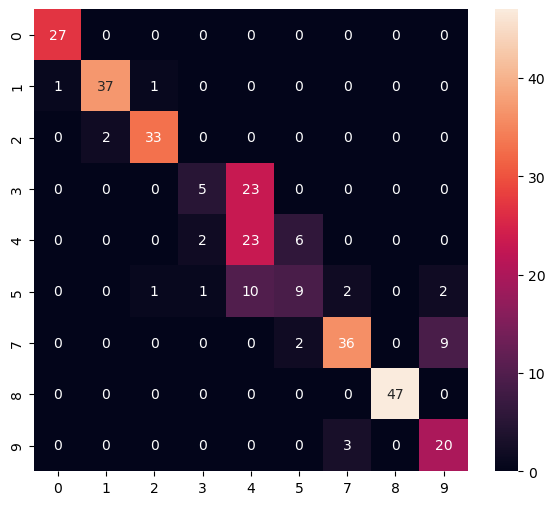

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       0.95      0.95      0.95        39
           2       0.94      0.94      0.94        35
           3       0.62      0.18      0.28        28
           4       0.41      0.74      0.53        31
           5       0.53      0.36      0.43        25
           7       0.88      0.77      0.82        47
           8       1.00      1.00      1.00        47
           9       0.65      0.87      0.74        23

    accuracy                           0.78       302
   macro avg       0.77      0.76      0.74       302
weighted avg       0.80      0.78      0.77       302



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [16]:

# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp1cbl0j1r/assets


2022-12-11 19:16:44.545490: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-11 19:16:44.545530: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-11 19:16:44.546967: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1cbl0j1r
2022-12-11 19:16:44.551490: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-11 19:16:44.551732: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1cbl0j1r
2022-12-11 19:16:44.572654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-11 19:16:44.576503: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-11 19:16:44.757891: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1cbl0j1r
2022-12

6808